# California Price Prediction

In this notebook we will use the [California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices) dataset to apply some EDA techniches and implement diverse regression models to accurately predict the price of the houses based on different variables.

## Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

## Loading the dataset

In [4]:
working_dir = "C://Users/marti/Cosas de Martin/Proyectos/Programación/House-Price-Prediciton/"

In [5]:
df_california = pd.read_csv(working_dir+"Data/housing.csv")

In [6]:
df_california.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Exploratory Analysis

Let's get familiar with the data that we have and see if we need to correct some of them or we are able to get some useful insight before the prediciton section.

In [7]:
df_california.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


With the exception of `ocean_proximity`, every other variable has numeric values, something that we could expected. 

The `total_bedrooms` ones has some missing values. As they are not a lot, we can simply drop them.

In [8]:
df_california_2 = df_california.dropna()

In [9]:
df_california_2["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

All these values look like valid ones. We can start to see that the distribution of their counts, and probably prices, won´t be uniform since it looks like most of the houses are very proximate to the ocean.

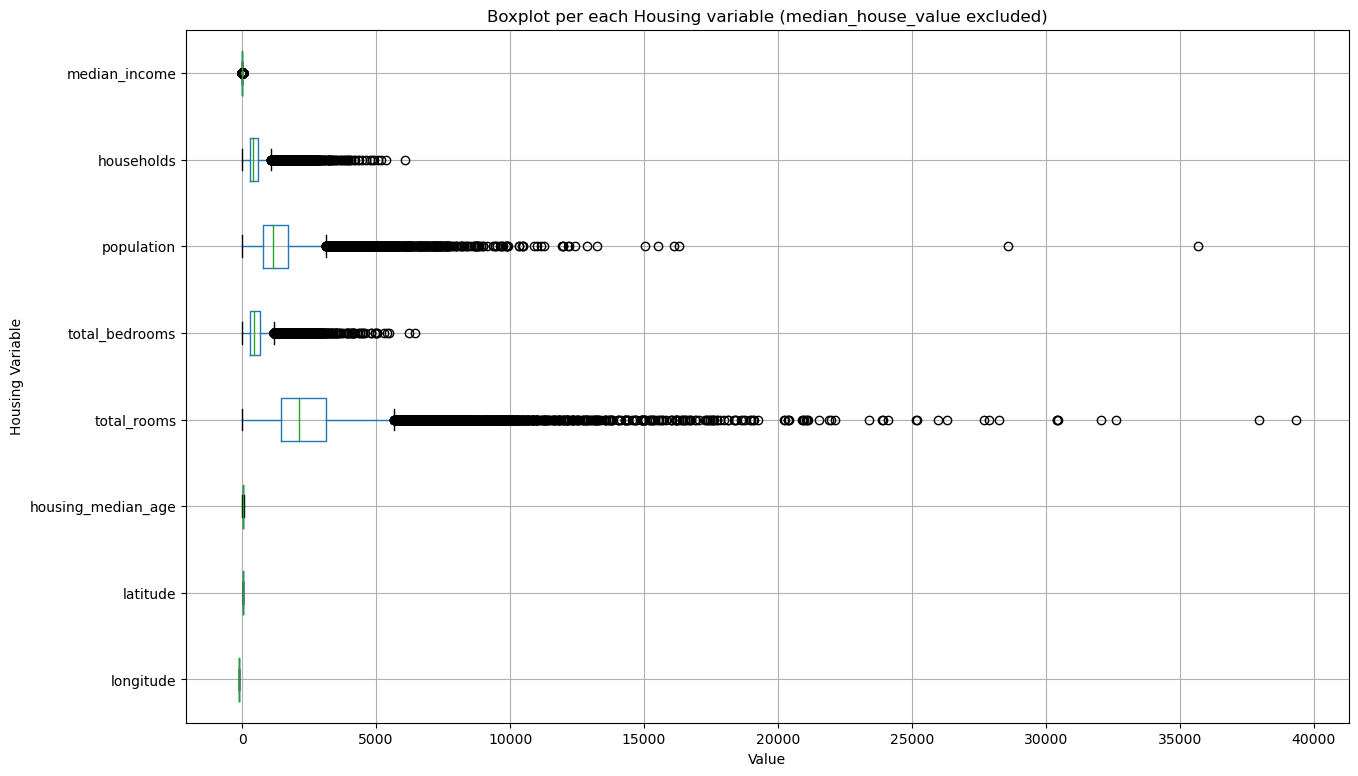

In [10]:
plt.figure(figsize=(15, 9))
df_california_2.drop(columns=["median_house_value"]).boxplot(vert=False)
plt.ylabel("Housing Variable")
plt.xlabel("Value")
plt.title("Boxplot per each Housing variable (median_house_value excluded)")
plt.show()

This doesn´t look good, since they use different scales, it will be better to do a boxplot per each of the variables that we have.

In [11]:
numerical_data = df_california_2.drop(columns=["ocean_proximity"])

In [12]:
cols = numerical_data.columns
len(cols)

9

c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

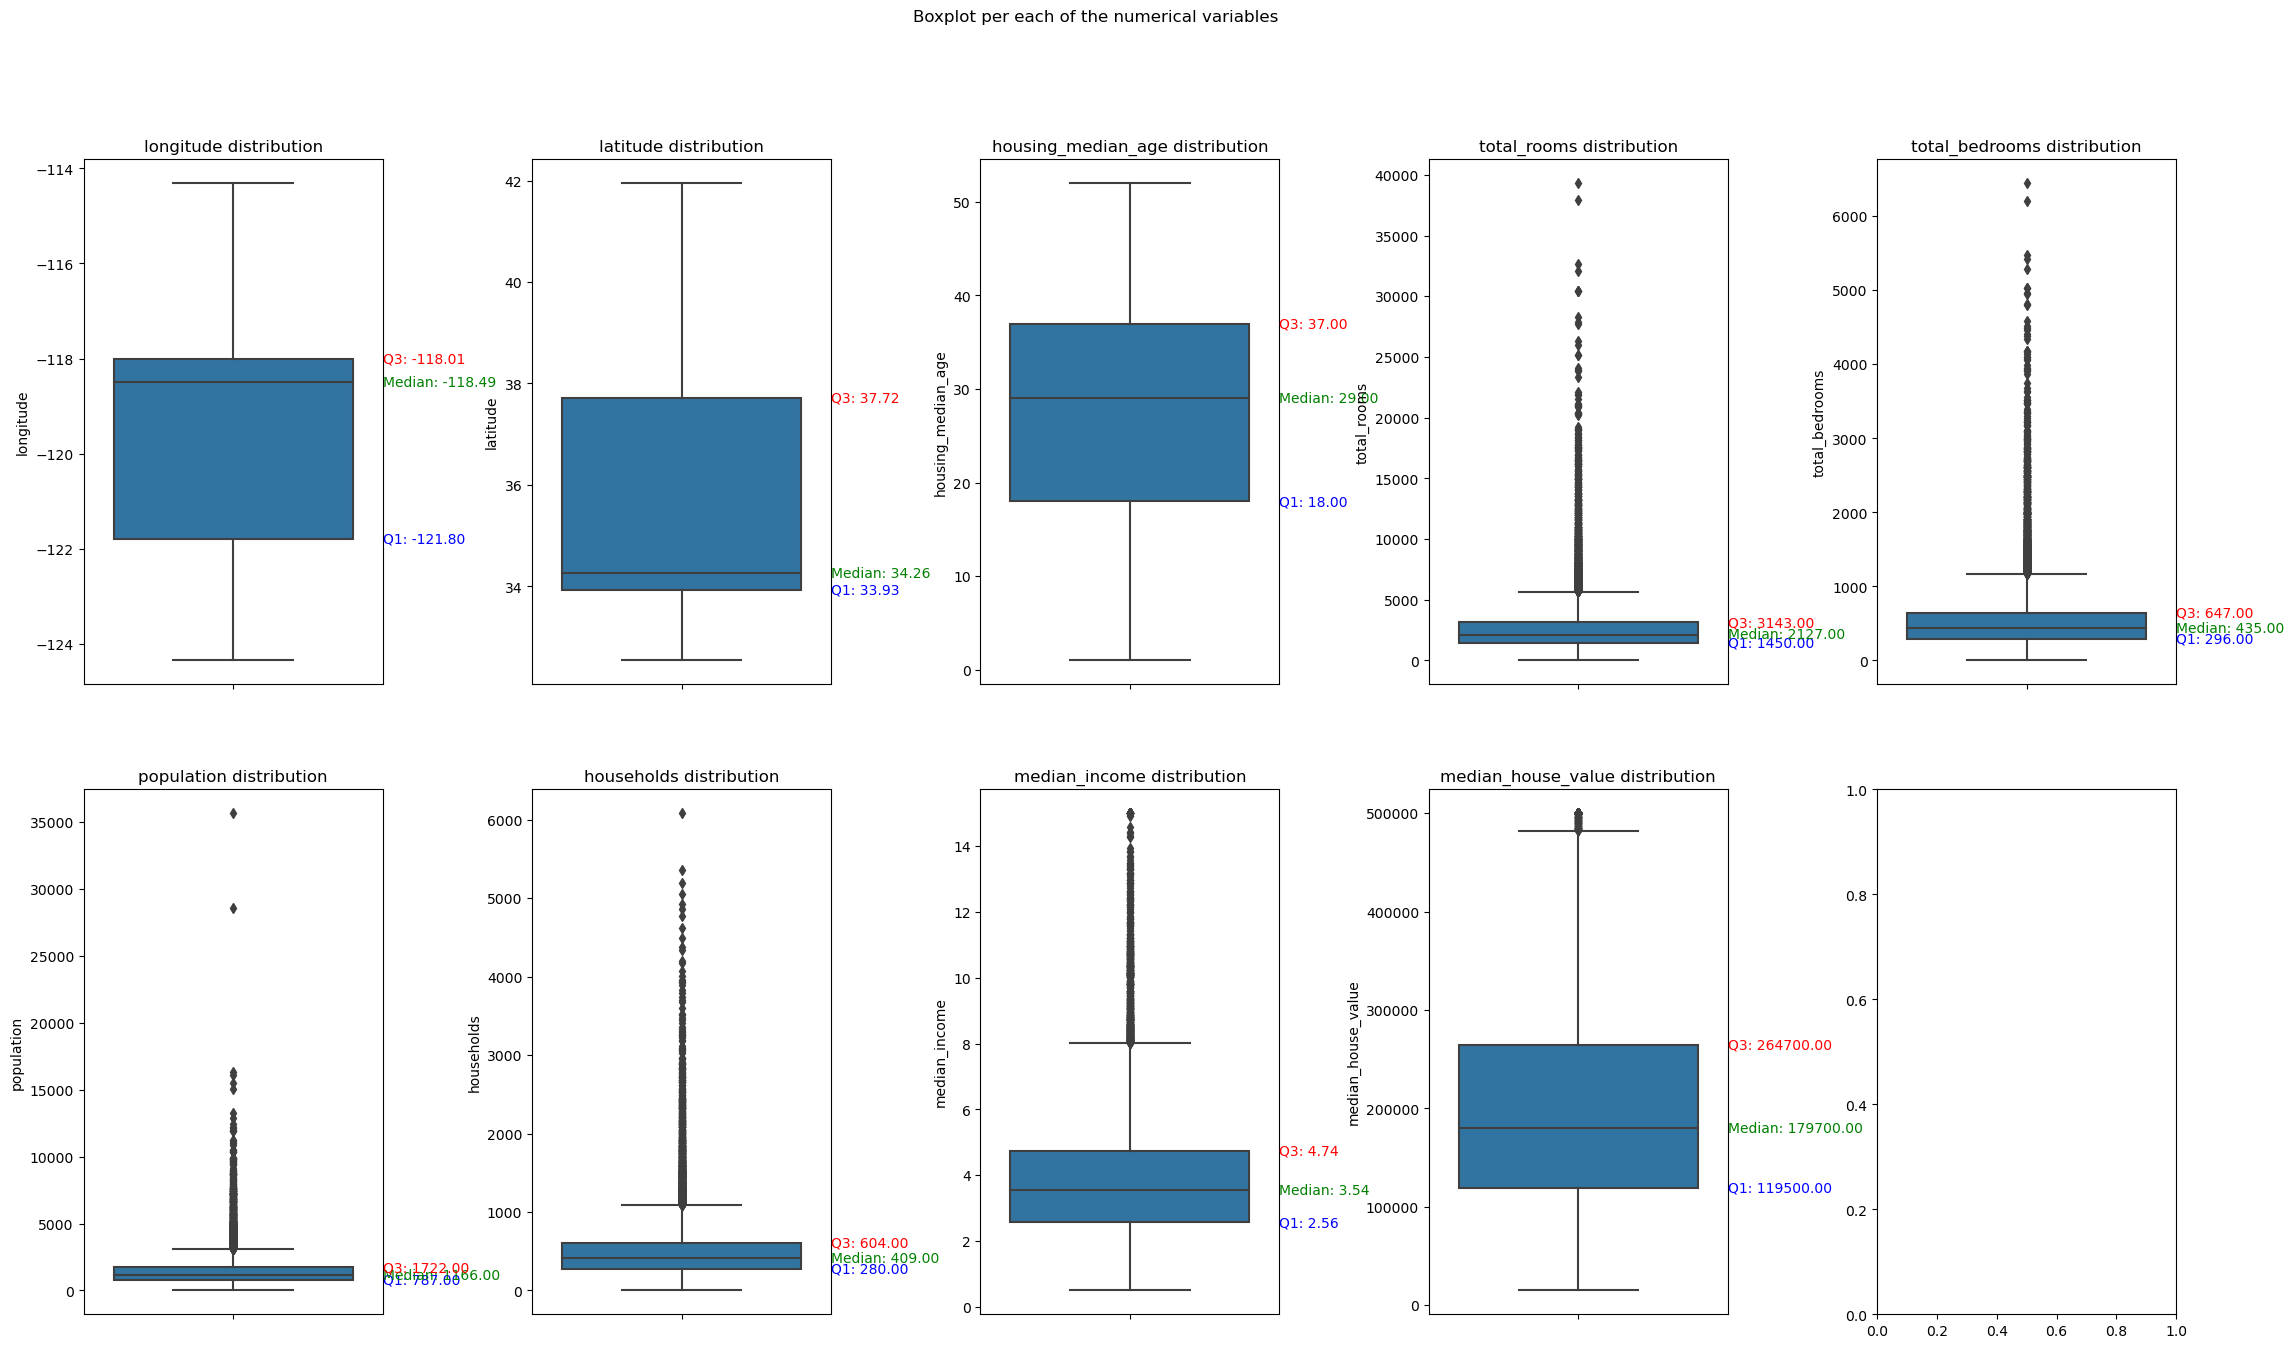

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(27, 15))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.5)

for i in range(0, len(cols)):

    variable = cols[i]
    variable_data = numerical_data[variable]

    quantile_25 = variable_data.quantile(0.25)
    median = variable_data.quantile(0.50)
    quantile_75 = variable_data.quantile(0.75)

    sns.boxplot(y = variable_data, ax=ax[i])

    ax[i].text(0.50, quantile_25, f'Q1: {quantile_25:.2f}', verticalalignment='center', color='blue', fontsize=10)
    ax[i].text(0.50, median, f'Median: {median:.2f}', verticalalignment='center', color='green', fontsize=10)
    ax[i].text(0.50, quantile_75, f'Q3: {quantile_75:.2f}', verticalalignment='center', color='red', fontsize=10)

    ax[i].set_title(f"{variable} distribution")



plt.suptitle("Boxplot per each of the numerical variables")
plt.show()

While the `Longitude` and `Latitude` looks like have a bias to higher and lower values respectively (we will see that is makes sense if we consider California's geographic shape), the `housing_median_age` is pretty simetric. Similar look `median_house_value`, but with an slighlty more centered to lower values boxplot body.

For all the other boxplots, we can see a really big amount of outliers, at least based on the boxplot 1.5 IQR criteria.

Because of their quantity, they don´t really seem like so.

But as we have a categorical variable in our dataset, `ocean_proximity`, we can see if this trend persists we we discriminate the data based on this.

In [14]:
ocean_proximity = df_california_2["ocean_proximity"]

c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

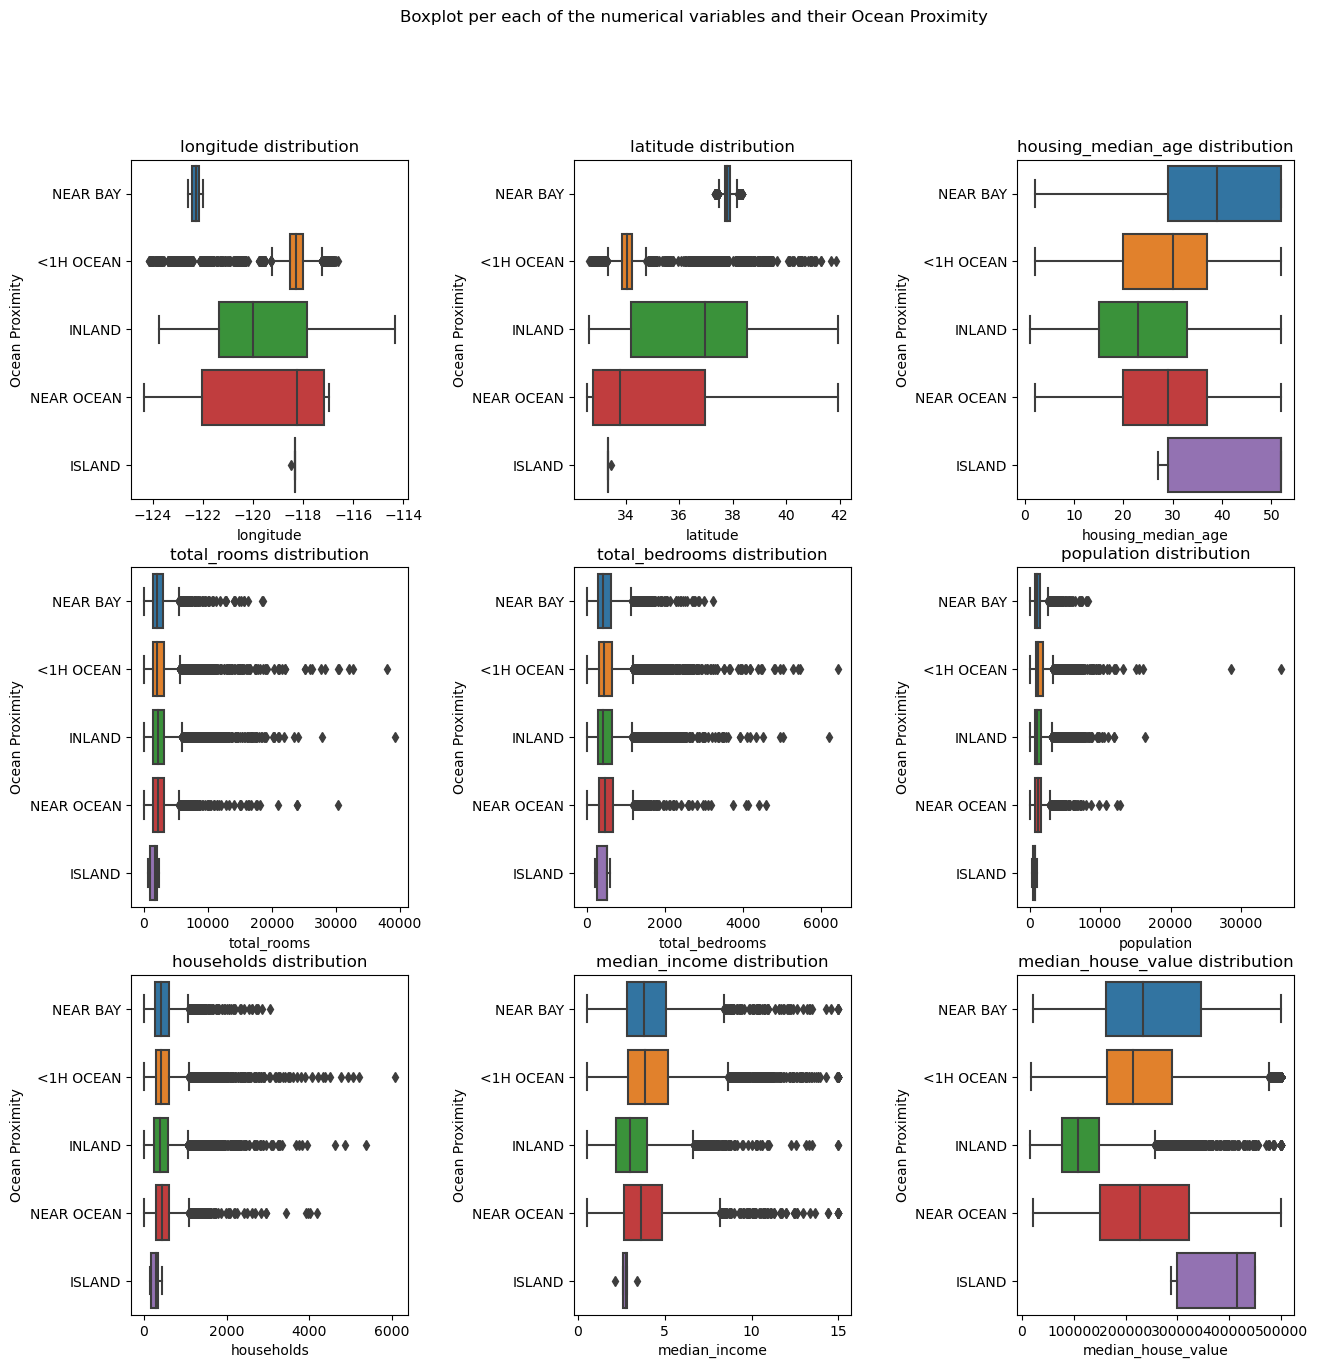

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.6, hspace=0.2)

for i in range(0, len(cols)):

    variable = cols[i]
    variable_data = numerical_data[variable]

    quantile_25 = variable_data.quantile(0.25)
    median = variable_data.quantile(0.50)
    quantile_75 = variable_data.quantile(0.75)

    sns.boxplot(x = variable_data, ax=ax[i], y=ocean_proximity)

    #ax[i].text(0.50, quantile_25, f'Q1: {quantile_25:.2f}', verticalalignment='center', color='blue', fontsize=10)
    #ax[i].text(0.50, median, f'Median: {median:.2f}', verticalalignment='center', color='green', fontsize=10)
    #ax[i].text(0.50, quantile_75, f'Q3: {quantile_75:.2f}', verticalalignment='center', color='red', fontsize=10)

    ax[i].set_title(f"{variable} distribution")
    ax[i].set_ylabel("Ocean Proximity")
    ax[i].set_yticklabels(ax[i].get_yticklabels())



plt.suptitle("Boxplot per each of the numerical variables and their Ocean Proximity")
plt.show()

We can observe how the `Longitude` and `Latitude` are variating as a function of the `ocean_proximity`, it's something that we could suppose to happen.

For most of the variables, the distribution didn´t improve, we can also see a lot of outliers with higher values than the `IQR` for their boxplots. The `ISLAND` ones look something weird, but it is just because it has only five values.

In the `median_house_value` we can see that `INLAND` look like it is centered to lower prices. However, it has a lot of higher values outliers. For the rest, their boxplot are pretty simetric.

**INSIGHT:** Although the distribution view didn´t improve in general, we can notice that the `NEAR BAY`is by far the one with the bigger (relative) amount of oldest houses and `INLAND` is the one with the less.

c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


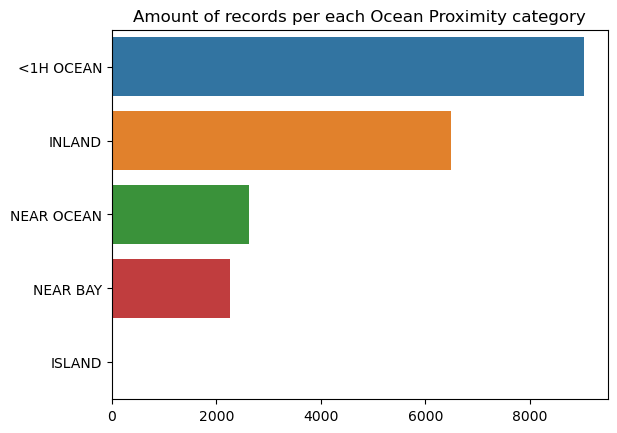

In [16]:
plt.figure()
sns.barplot(x=df_california_2["ocean_proximity"].value_counts().values, y=df_california_2["ocean_proximity"].value_counts().index)
plt.title("Amount of records per each Ocean Proximity category")
plt.ylabel("")
plt.show()

Here we have a different picture, `NEAR BAY` is the one with the less counts if we don´t take in consideration `ISLAND`.

We can see how different are each category from the other visually.

c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

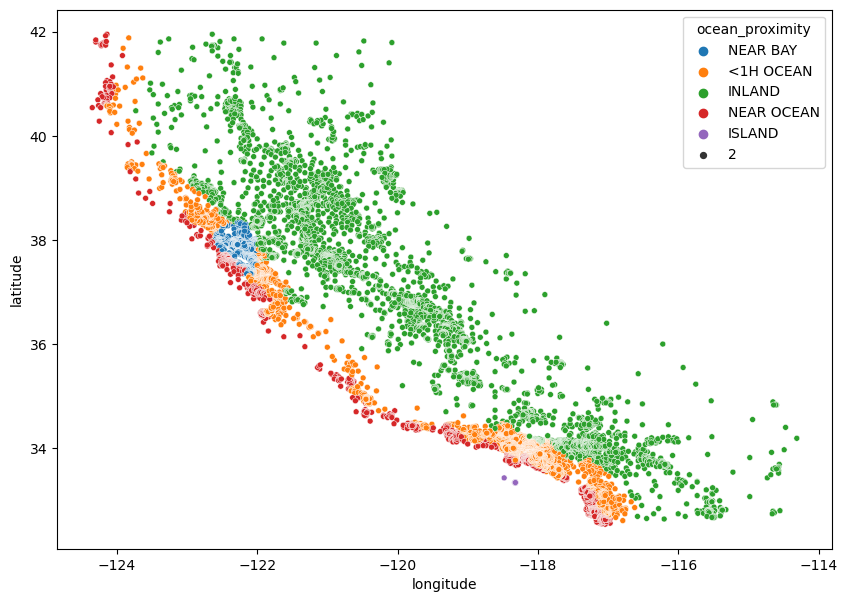

In [17]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_california_2, x="longitude", y="latitude", hue="ocean_proximity", size=2)
plt.show()

It has California's shape.

**INSIGHTS**: 
- `INLAND` is very different from all the other categories in terms of their locations distribution, as it encompasses a bigger area of the state. That maybe make us think that this is not the best classification for the records. 
- Is remarkable that `NEAR BAY` records are all of them concentrated in what we know is the bay of California, near San Francisco. 
- There is other cluster of records in the south of the state, we can see that's what made the `1<H OCEAN` really boxplot really narrow and with a lot of outliers before. It is around the city of Los Angeles. A bit souther there is San Diego, which seems to also have a considerable amount of records.

So, big cities seems to have more records near them, that's something that sound reasonable. But we can also see that `ocean_proximity` may not be the bes way in which we can classificate our rows, since it has a really high variance.

We can take a look to this kind of *clustering* distribution among our dataset with some histograms and density plots.

c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\marti\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

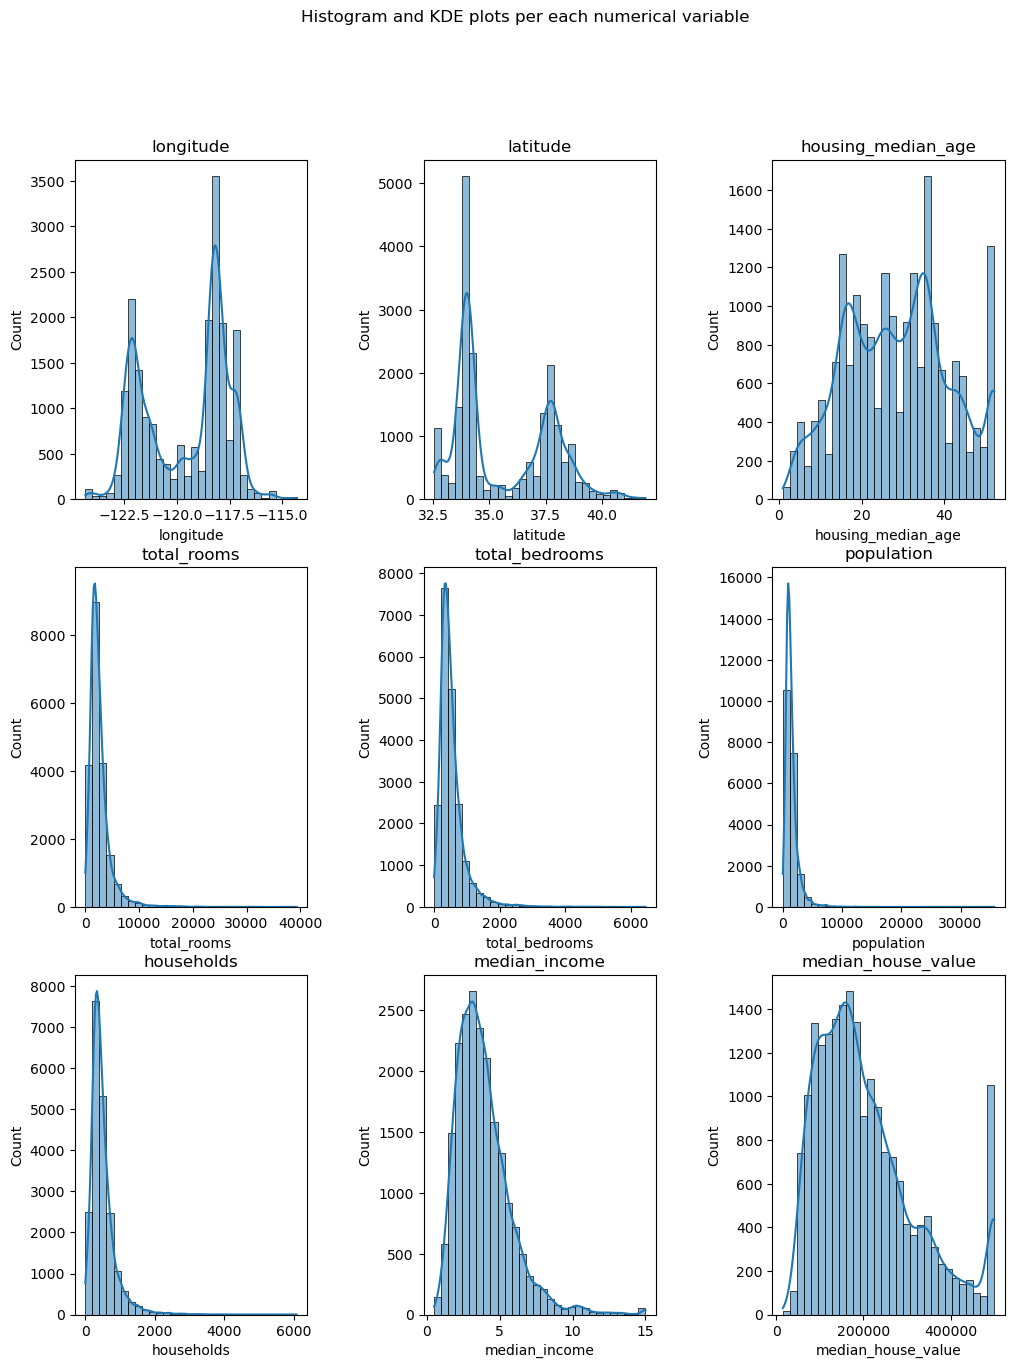

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 15))
ax = ax.flatten()
fig.subplots_adjust(wspace=0.5, hspace=0.2)

for i in range(0, len(cols)):
    variable = cols[i]
    variable_data = df_california_2[variable]

    sns.histplot(x=variable_data, kde=True, bins=30, ax=ax[i])
    
    ax[i].set_title(f'{variable}')

plt.suptitle("Histogram and KDE plots per each numerical variable")
plt.show()

The bimodal distribution is clear in the case of `latitude` and `longitude`. 

For the other cases, it is centered to lower values within their min-max range. However, the `median_income` looks like if it has some relevant amount amount of higher values with that noticeable bar around 15.

This outlier-like records are more highlighted in `median_house_value`.

There are more like 1.000 record with median prices higher than 400.000

The `housing_median_age` looks the more chaotic.

**INSIGHT**: based on the coordinates and slightly less in the `median_house_values`, it looks like there are two hidden clusters.

But remembering that our goal is to predict the price of the house as a function of the rest of the variables, we should see how they are correlated.

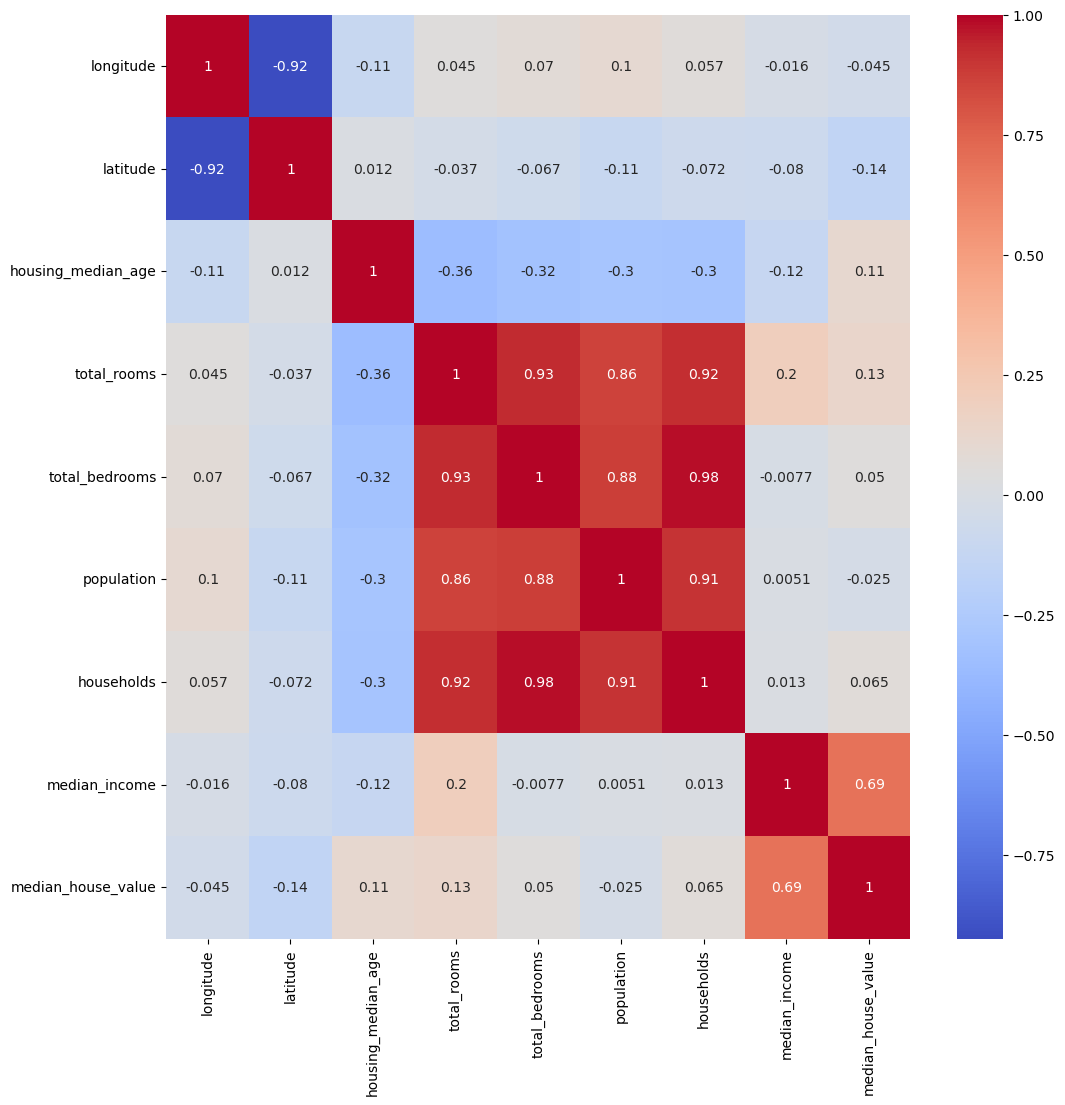

In [19]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=numerical_data.corr(), cmap="coolwarm", annot=True)
plt.show()

This starts to look more interesting.

As we can see before, the `longitude` and `latitude` define two clusters, and here we can see that they are strongly negatively linear correlated.

We can see that our target variable, the `median_house_value` has a positive strong correlation with the `median_income`, it makes sense that the richer regions also have higher prices.

But also, there are lots of strong positive correlations between the `bedrooms` and `population` related variables, we can think that this is due to the fact that, as population increases, the needed of houses does so.

**INSIGHT**: different variables seems like tell us something about things that are strongly (linear) correlated, we may think of reduce the dimensions of our dataset.

### Dimensionality Reduction

It looks like some variables are redundant, and can be linear described as a function of others because of their strong Pearson correlation coeficient. We can apply an algorithm that can take advantage of this situation to get a different visualization of our dataset and look if the our hidden *cluster* suspect improves. That algorithm is `PCA`.

As it works with distances, we will need to normalize our values.

In [20]:
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

In [21]:
n_components = 9

pca = PCA(n_components=n_components)
pca.fit_transform(numerical_data_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()


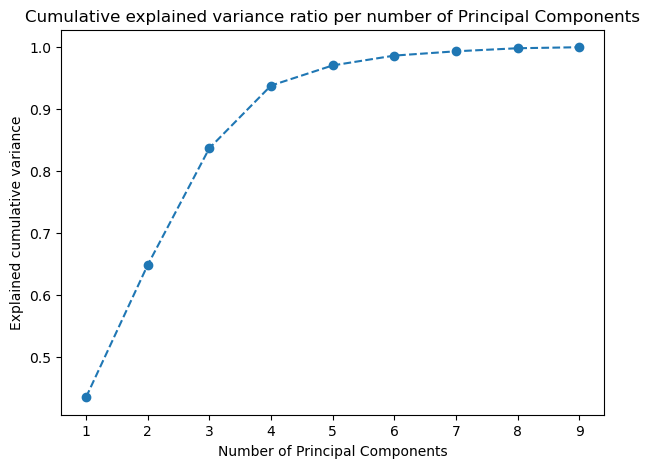

In [22]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative explained variance ratio per number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained cumulative variance')
plt.show()

We can see that with just three PC we can explain almost 85% of the variance. That's a really high ratio, and also a good number for visualization, since we can do a 3D scatterplot.

In [23]:
pca = PCA(n_components=3)
numerical_data_pca = pca.fit_transform(numerical_data_scaled)

In [24]:
numerical_data_pca

array([[-1.96781667,  0.54460165,  3.59326044],
       [ 3.01546914,  1.3071318 ,  2.88792402],
       [-1.88826505,  0.85002648,  2.67367899],
       ...,
       [-0.51134524,  2.11680388, -1.02660343],
       [-0.9242834 ,  2.09630871, -0.97933496],
       [ 0.07847097,  2.11500363, -0.83026998]])

In [25]:
def pca_data_scatterpot(pca_data=numerical_data_pca, elev=0, azim=0):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
       pca_data[:, 0],
       pca_data[:, 1],
       pca_data[:, 2],
    )

    ax.view_init(elev=elev, azim=azim)


    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    plt.title('Scatterplot 3D of Principal Components by Ocean Proximity')
    plt.show()

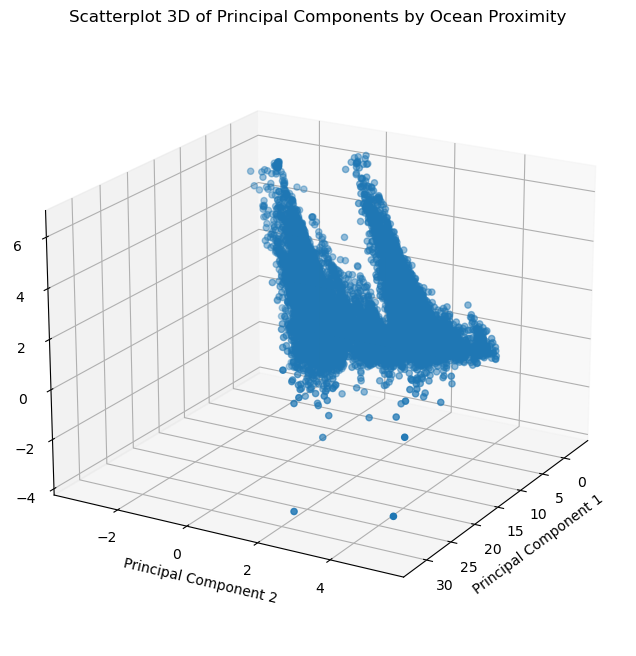

In [26]:
pca_data_scatterpot(elev=20, azim=30)

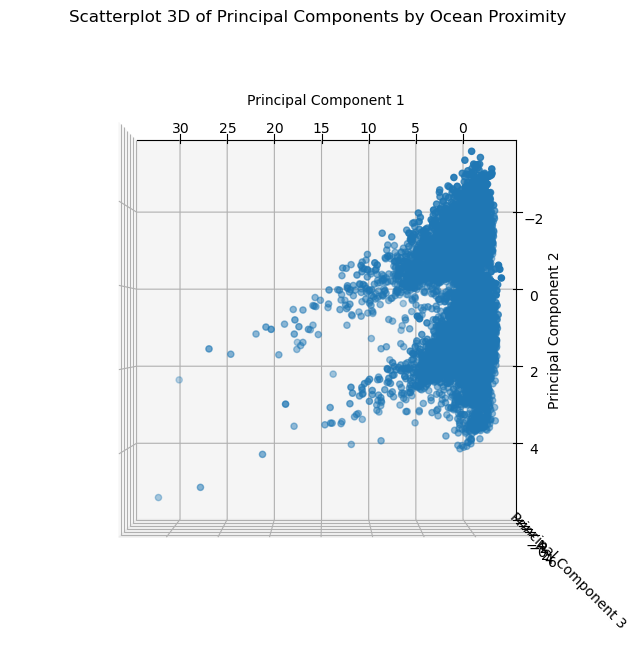

In [27]:
pca_data_scatterpot(elev=90, azim=90)

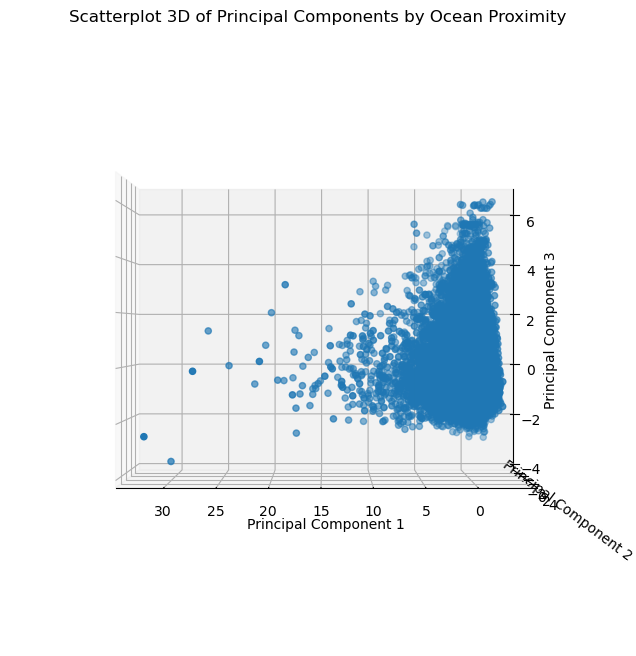

In [28]:
pca_data_scatterpot(elev=0, azim=90)

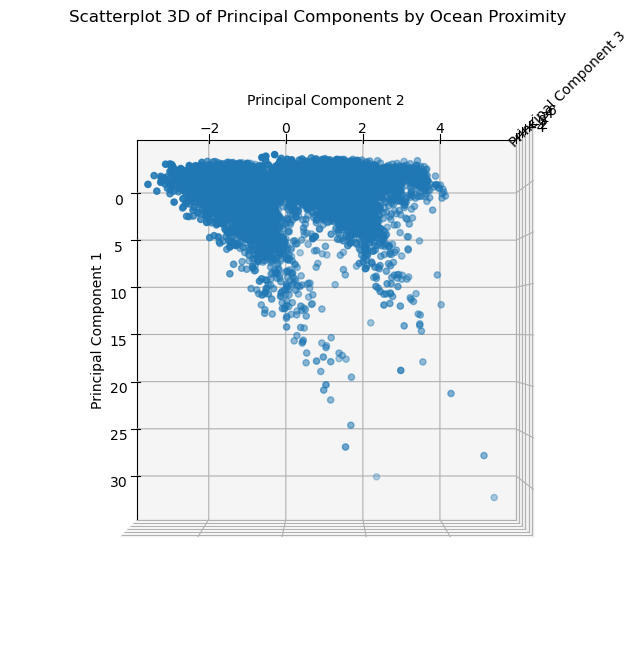

In [29]:
pca_data_scatterpot(elev=90, azim=0)

It looks like there are, at least, two different clusters that are connected in some way.

They are not as separated as we may wanted.

**INSIGHT**: There are two easy distinguible clusters. However, they are really close to each other, and they have an area of contact.

### Clustering

The last insight may be crucial for our algorithm selection to get new labels for this dataset.

Our initial EDA and now the PCA dimension reduction shows strong evidence in favor that there are two different clusters hidden in our datasets. However, due to the the previous observation, we can think that the best option will be an algorithm based on *density* to discriminate different groups.

Because of this, we will use `DBSCAN` as our cluster algorithm, since it can handle this *strange* forms well.

Anyways, because we have strong evidence that the amount of correct clusters is 2, we will also try `KMeans` and use its metrics score as a lower limit to select the `DBSCAN` hyperparameters, if it is the case that we find a better density based algorithm.

#### K-Means

In [30]:
k_values = range(2, 10)

inertia_scores = []
silhouette_scores = []

for k in k_values:
    #the random state is just to make this notebook always have the same result
    kmeans = KMeans(n_clusters = k, random_state=42)
    clusters = kmeans.fit_predict(numerical_data_pca)

    silhouette_avg_score = silhouette_score(numerical_data_pca, clusters)
    
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_avg_score)

c:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marti\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\marti\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


c:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

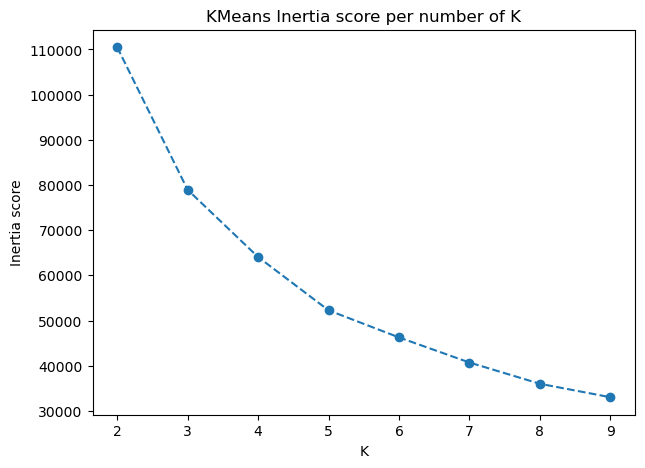

In [31]:
plt.figure(figsize=(7, 5))
plt.plot(k_values, inertia_scores, marker='o', linestyle='--')
plt.title('KMeans Inertia score per number of K')
plt.xlabel('K')
plt.ylabel('Inertia score')
plt.show()

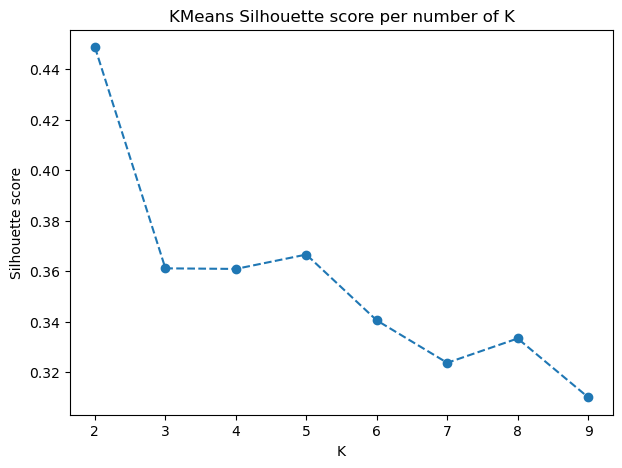

In [32]:
plt.figure(figsize=(7, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('KMeans Silhouette score per number of K')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_clusters = kmeans.fit_predict(numerical_data_pca)

c:\Users\marti\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [57]:
kmeans_series = pd.Series(kmeans_clusters)
kmeans_series.value_counts()

0    18074
1     2359
Name: count, dtype: int64

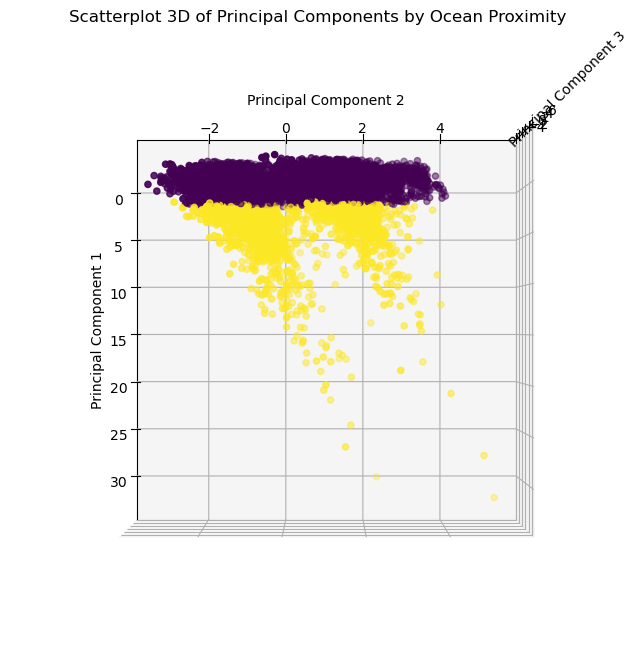

In [56]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    numerical_data_pca[:, 0],
    numerical_data_pca[:, 1],
    numerical_data_pca[:, 2],
    c=kmeans_clusters
)

ax.view_init(elev=90, azim=0)


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.title('Scatterplot 3D of Principal Components by Ocean Proximity')
plt.show()

Based on the `Inertia` score, which is defined as the mean squared distance between each data point and its closest centroid, we are not able to select an optimal number for $K$, since there is no local minimum to apply the *elbow rule*. 

However, for the `Silhouette` one, which tells us how well classified are our data points (and we want to maximize it then), the best value is about `0.45` for $K = 2$.

It is not a lot, but we can use it as a minimum for our

#### DBSCAN

In [35]:
epsilons = [0.0001, 0.001, 0.01, 0.1, 1]
min_neighbors = [3, 5, 7, 11, 13, 17]

epsilon_neighbors_pairs = []
silhouette_scores = []


for e in epsilons:
    for n in min_neighbors:

        pair = (e, n)
        
        dbscan = DBSCAN(eps=e, min_samples=n)
        clusters = dbscan.fit_predict(numerical_data_pca)

        # In case there is some pair that returns only one cluster
        try:
            silhouette_avg_score = silhouette_score(numerical_data_pca, clusters)
        except:
            silhouette_avg_score = 0

        epsilon_neighbors_pairs.append(pair)
        silhouette_scores.append(silhouette_avg_score)

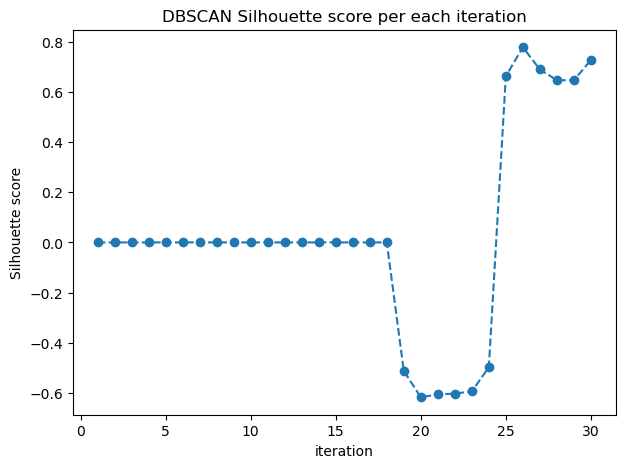

In [43]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(silhouette_scores)+1), silhouette_scores, marker='o', linestyle='--')
plt.title('DBSCAN Silhouette score per each iteration')
plt.xlabel('iteration')
plt.ylabel('Silhouette score')
plt.show()

The best Silhouette Score was got something about the 25 iterations, and it is almost 0.80

In [45]:
silhouette_scores[24:]

[0.6630738817355999,
 0.7792415656777789,
 0.6906342087357458,
 0.6475528478122672,
 0.6473499464566682,
 0.7278182976580446]

In [47]:
epsilon_neighbors_pairs[24:]

[(1, 3), (1, 5), (1, 7), (1, 11), (1, 13), (1, 17)]

It corresponds to the `25` index pair in the pairs array.

In [48]:
best_hyperparameters = epsilon_neighbors_pairs[25] #(1, 5)

In [50]:
e , n = best_hyperparameters
dbscan = DBSCAN(eps=e, min_samples=n)
dbscan_clusters = dbscan.fit_predict(numerical_data_pca)

In [51]:
dbscan_series = pd.Series(dbscan_clusters)

In [52]:
dbscan_series.value_counts()

 0    20372
-1       53
 1        8
Name: count, dtype: int64

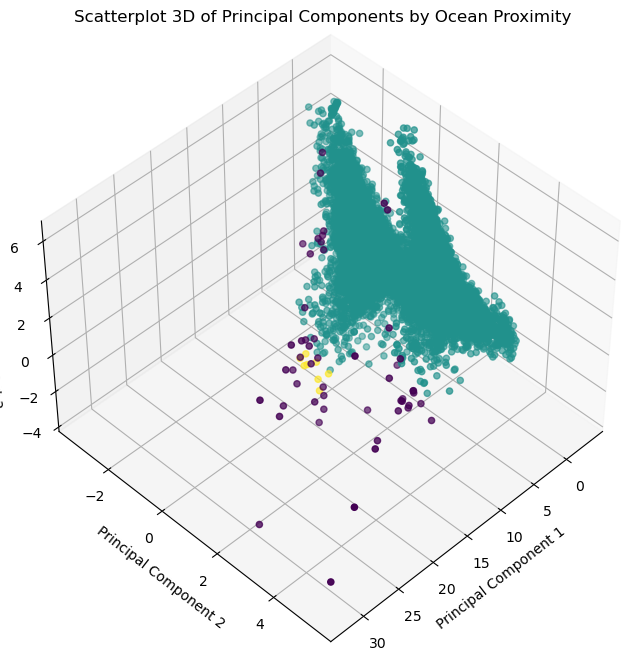

In [53]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    numerical_data_pca[:, 0],
    numerical_data_pca[:, 1],
    numerical_data_pca[:, 2],
    c=dbscan_clusters
)

ax.view_init(elev=45, azim=45)


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.title('Scatterplot 3D of Principal Components by Ocean Proximity')
plt.show()

Doesn´t seem like a good separation, even if it doubled the previous silhouette score.

Almost all of the data is part of the same cluster, which is not really informative.

### Clustering Selection

Because of this non-informative contribution of the DBSCAN, we will go with KMeans this time, since it gives us more information, and the proportion of 18.000 - 2.000 records that it gave us for the clusters may even make sense considering that there were a lot of values really concentrated for each variable and also a lot of outliers with higher values for each of them.

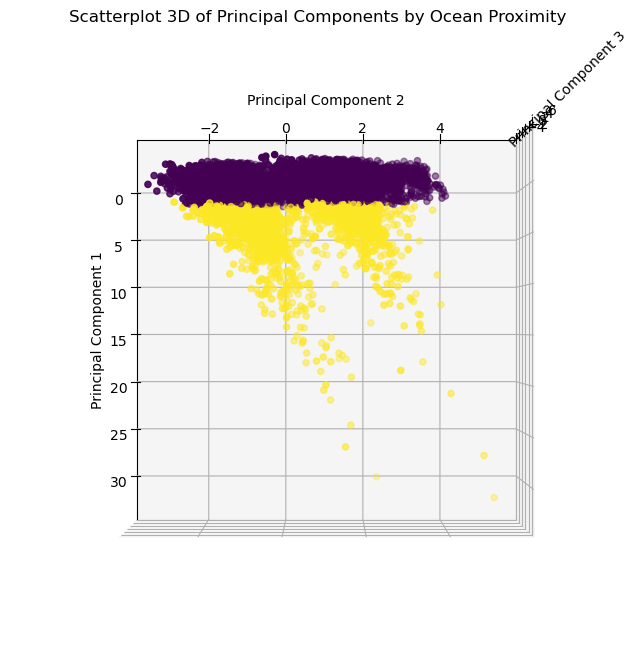

In [58]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    numerical_data_pca[:, 0],
    numerical_data_pca[:, 1],
    numerical_data_pca[:, 2],
    c=kmeans_clusters
)

ax.view_init(elev=90, azim=0)


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.title('Scatterplot 3D of Principal Components by Ocean Proximity')
plt.show()

Here that's what we have, some really concentrated values and the others that go away (in the same direction) from them.

In [59]:
df_california_2["cluster"] = kmeans_series

C:\Users\marti\AppData\Local\Temp\ipykernel_4504\589207516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_california_2["cluster"] = kmeans_series


In [60]:
df_california_2

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0.0
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,NaN
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,NaN
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,NaN
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,NaN
